# Tibia Auction Market Analysis - Data Exploration

 The goal of this project is to understand what truly influences the price of in-game characters. Instead of guessing, I'm analyzing thousands of historical auctions to identify specific patterns. This part focuses on data analysis and identifying which character stats matter most to buyers.

## Analysis Goals:
1. **Data Exploration** - understanding data structure and quality
2. **Price Trend Analysis** - identifying temporal patterns
3. **World Segmentation** - grouping by market characteristics
4. **Preparation for Predictive Modeling**

## Research Questions:
- Which factors most influence character prices?
- Are there differences between worlds (PvP vs PvE)?
- What does seasonality look like in the market?
- Can we predict future prices?


Libraries imports

In [2]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Database connection
import psycopg2
from sqlalchemy import create_engine, text


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Statistical analysis
from scipy.stats import pearsonr

# Configuration
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

print("Libraries imported successfully.")

Libraries imported successfully.


Connection with database

In [3]:
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Database connection config from environment variables
DB_CONFIG = {
    'host': os.getenv('DB_HOST', 'localhost'),
    'port': os.getenv('DB_PORT', '5432'),
    'database': os.getenv('DB_NAME', 'auction_data'),
    'user': os.getenv('DB_USER', 'scraper'),
    'password': os.getenv('DB_PASSWORD')
}

# Create connection string
connection_string = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"

# Create engine
engine = create_engine(connection_string)

print("Database connection configured.")


Database connection configured.


In [4]:
index_queries = [
    "CREATE INDEX IF NOT EXISTS idx_auctions_character_id ON auctions(character_id);",
    "CREATE INDEX IF NOT EXISTS idx_auctions_filters ON auctions(has_been_bidded, is_historical);",
    "CREATE INDEX IF NOT EXISTS idx_characters_skills_id ON characters(skills_id);",
    "CREATE INDEX IF NOT EXISTS idx_characters_world_id ON characters(world_id);"
]

for query in index_queries:
    try:
        with engine.connect() as conn:
            conn.execute(text(query)) 
            conn.commit()              
        print(f"Index created: {query}")
    except Exception as e:
        print(f"Error: {e}")


Index created: CREATE INDEX IF NOT EXISTS idx_auctions_character_id ON auctions(character_id);
Index created: CREATE INDEX IF NOT EXISTS idx_auctions_filters ON auctions(has_been_bidded, is_historical);
Index created: CREATE INDEX IF NOT EXISTS idx_characters_skills_id ON characters(skills_id);
Index created: CREATE INDEX IF NOT EXISTS idx_characters_world_id ON characters(world_id);


In [5]:
# Get all tables and their columns
schema_query = """
SELECT 
    table_name,
    column_name,
    data_type,
    is_nullable
FROM information_schema.columns 
WHERE table_schema = 'public'
ORDER BY table_name, ordinal_position;
"""

schema_df = pd.read_sql(schema_query, engine)
print("Database schema:")
print(schema_df.to_string(index=False))


Database schema:
                 table_name         column_name                   data_type is_nullable
                   auctions                  id                     integer          NO
                   auctions        character_id                     integer         YES
                   auctions         auction_end                      bigint          NO
                   auctions         current_bid                     integer          NO
                   auctions     has_been_bidded                     boolean          NO
                   auctions       is_historical                     boolean          NO
                   auctions          scraped_at timestamp without time zone         YES
     character_greater_gems                  id                     integer          NO
     character_greater_gems        character_id                     integer         YES
     character_greater_gems     gem_description           character varying          NO
     character_

The database consists of several interconnected tables that provide a comprehensive overview of each auction. The most important of these are:

- auctions: contains hard transaction data (final prices, end dates).
- characters: main table with character data (level, profession, unlocked add-ons such as Prey Slots or Charm Expansion).
- skills: detailed skill levels (magic level, sword, distance, etc.).
- worlds: server information (PvP type, location, BattlEye system).

This breakdown allows me to analyze not only the raw character level but also the value of premium add-ons and how much the server type affects the final price.

In [24]:
schema_query = """
SELECT 
    a.id AS auction_id,
    a.current_bid,
    a.auction_end,
    a.has_been_bidded,
    c.id AS character_id, 
    c.vocation_id, 
    c.level, 
    c.sex,
    c.achievement_points,
    c.boss_points,
    c.charm_total,
    c.charm_expansion,
    c.prey_slot,
    c.hunting_slot,
    c.transfer,
    c.gems_greater,
    c.outfits_count,
    c.mounts_count,
    c.store_mounts_count,
    c.store_outfits_count,
    c.hirelings_count,
    s.magic, s.axe, s.sword, s.club, s.distance, s.shielding, s.fist,
    w.pvp_type,
    w.battleye,
    w.location
FROM auctions a 
JOIN characters c ON a.character_id = c.id
LEFT JOIN skills s ON c.skills_id = s.id
LEFT JOIN worlds w ON c.world_id = w.id
WHERE a.is_historical = true
"""
auctions_df = pd.read_sql(schema_query, engine)

auctions_df['auction_end_dt'] = pd.to_datetime(auctions_df['auction_end'], unit='s')
auctions_df['auction_month'] = auctions_df['auction_end_dt'].dt.month
auctions_df['auction_day_of_week'] = auctions_df['auction_end_dt'].dt.dayofweek

display(auctions_df.head())
print(auctions_df.info())

,auction_id,current_bid,auction_end,has_been_bidded,character_id,vocation_id,level,sex,achievement_points,boss_points,charm_total,charm_expansion,prey_slot,hunting_slot,transfer,gems_greater,outfits_count,mounts_count,store_mounts_count,store_outfits_count,hirelings_count,magic,axe,sword,club,distance,shielding,fist,pvp_type,battleye,location,auction_end_dt,auction_month,auction_day_of_week
0,1968898,303,1759345200,True,1968898,2,238,False,129,0,1215,False,False,False,False,0,17,4,0,0,0,28.13,13.79,30.53,23.91,110.66,99.80,13.74,Open,False,NA,2025-10-01 19:00:00,10,2
1,1967415,2000,1759136400,True,1967415,2,346,False,443,2610,2982,False,False,False,True,0,34,27,1,0,0,30.95,12.94,30.07,12.94,115.01,103.26,16.17,Open,False,NA,2025-09-29 09:00:00,9,0
2,1970838,851,1759568400,True,1970838,2,59,True,16,40,30,False,False,False,True,0,13,1,0,0,0,17.16,14.36,16.70,14.36,122.78,112.79,10.10,Optional,False,NA,2025-10-04 09:00:00,10,5
3,1304164,3901,1690329600,True,1304164,2,368,False,200,1400,3661,False,True,False,True,0,15,6,0,2,0,30.86,13.48,13.48,13.48,109.11,93.34,21.84,Open,True,BR,2023-07-26 00:00:00,7,2
4,1960648,500,1758358800,True,1960648,3,240,False,198,10,785,False,False,False,True,0,24,18,0,0,0,84.46,13.14,16.50,12.49,12.58,30.39,21.38,Open,True,BR,2025-09-20 09:00:00,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1193757 entries, 0 to 1193756
Data columns (total 34 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   auction_id           1193757 non-null  int64         
 1   current_bid          1193757 non-null  int64         
 2   auction_end          1193757 non-null  int64         
 3   has_been_bidded      1193757 non-null  bool          
 4   character_id         1193757 non-null  int64         
 5   vocation_id          1193757 non-null  int64         
 6   level                1193757 non-null  int64         
 7   sex                  1193757 non-null  bool          
 8   achievement_points   1193757 non-null  int64         
 9   boss_points          1193757 non-null  int64         
 10  charm_total          1193757 non-null  int64         
 11  charm_expansion      1193757 non-null  bool          
 12  prey_slot            1193757 non-null  bool          
 1

In this step, I combined all the key information into a single table (DataFrame). This allows each auction to be described not only by its price but also by a full profile of the character and the world it resides in.

What I did:

1. I combined the tables using SQL queries to avoid duplicate data and maintain order.
2. I converted the raw time data into a readable date format (auction_end_dt).
3. I extracted the month and day of the week from the auction end date. This allows me to see if there are specific days or periods of the year when characters sell for higher prices (e.g., before major game updates).

# Skills analysis for each profession

In [25]:
vocation_skills = auctions_df.groupby('vocation_id').agg({
    'magic': 'mean',
    'distance': 'mean',
    'sword': 'mean',
    'axe': 'mean',
    'club': 'mean',
    'shielding': 'mean',
    'fist': 'mean',
    'auction_id' : 'count'
}).round(3)

vocation_skills.columns = ['avg_magic', 'avg_distance', 'avg_sword', 'avg_axe', 'avg_club', 'avg_shielding', 'avg_fist', 'count']
print("Average skills for each profession:")
display(vocation_skills)



Average skills for each profession:


,avg_magic,avg_distance,avg_sword,avg_axe,avg_club,avg_shielding,avg_fist,count
vocation_id,,,,,,,,
0,2.206,14.448,17.822,13.446,13.716,21.977,12.256,2331
1,9.474,19.211,75.298,58.582,53.218,101.246,16.090,365570
2,26.336,111.997,21.495,16.429,18.513,99.714,16.388,331753
3,86.116,15.621,14.844,12.882,13.565,33.508,13.425,214652
4,89.667,16.609,15.768,13.191,14.128,33.833,13.760,269320
5,31.627,13.890,14.040,13.505,13.978,57.689,88.258,10131


A preliminary analysis of average stats confirms clear differences between professions. This data is fundamental to understanding character value on the market.

Key Observations:
1. Specialization. We see that the highest skills align with game mechanics: for Knights (ID 1), these are melee and shielding skills, for Paladins (ID 2), distance fighting and shielding, and for magical professions (IDs 3 and 4), magic level. This data consistency ensures the quality of the data and allows for a reliable transition to the next stages of analysis.
2. Shielding. This stat is the most evenly distributed among combat professions, but significantly lower among mages, which is consistent with game mechanics.
3. Number of Characters. The distribution of auction numbers between professions is similar, meaning we have a sufficiently large sample size for each.

These differences demonstrate that it's impossible to compare characters 1:1 without taking into account their professions. For example, a Knight with a Magic Level of 100 would be unusual, while a Druid with a Magic Level of 100 is standard. This leads us to the need for skill normalization, which I will perform in the next step.

## Skills Normalization - Percentile Ranking by Vocation

Since skills have different difficulty scales across vocations, we need to normalize them to make fair comparisons.


In [31]:

skill_columns = ['magic', 'sword', 'axe', 'club', 'distance', 'shielding', 'fist']

print("Creating normalized skills (percentiles within vocation)...")

for skill in skill_columns:
    # Create percentile ranking within each vocation
    auctions_df[f'{skill}_percentile'] = auctions_df.groupby('vocation_id')[skill].rank(pct=True)
    
    # Also create z-score normalization for comparison
    auctions_df[f'{skill}_zscore'] = auctions_df.groupby('vocation_id')[skill].transform(
        lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0
    )

print("Normalization completed!")

# Show example of normalization for sword skill
print("\nExample - Sword skill normalization:")
sample_data = auctions_df[auctions_df['vocation_id'].isin([1,2])][
    ['vocation_id', 'sword', 'sword_percentile', 'sword_zscore']
].head(10)
display(sample_data)


Creating normalized skills (percentiles within vocation)...
Normalization completed!

Example - Sword skill normalization:


,vocation_id,sword,sword_percentile,sword_zscore
0,2,30.53,0.772154,1.002787
1,2,30.07,0.751622,0.951733
2,2,16.70,0.510007,-0.532179
3,2,13.48,0.144492,-0.889561
10,2,25.64,0.649132,0.460055
11,2,14.18,0.295984,-0.811870
12,2,13.32,0.114532,-0.907320
13,1,104.24,0.640902,0.758242
16,2,14.36,0.360823,-0.791892
19,2,35.65,0.923050,1.571047


Raw skill levels are incomparable between professions – a Knight's Magic Level of 100 is exceptional, while a Druid's is standard. To objectively assess a character's "power" in the predictive model, I introduced normalization within profession groups.

Logic used:
1. Percentiles. I assigned each character a value from 0 to 1, indicating the percentage of players of the same profession with a lower skill. This allows us to determine whether a given Knight is in the top 1% of their class in swordsmanship.
2. Z-score. I also calculated the deviation from the mean (standardization), which allows us to identify characters with extremely high stats, which can significantly increase their price.

This approach allows the model to understand that a character is valuable due to their unique training experience, regardless of profession.

Skill distribution comparison - Raw vs Percentile:


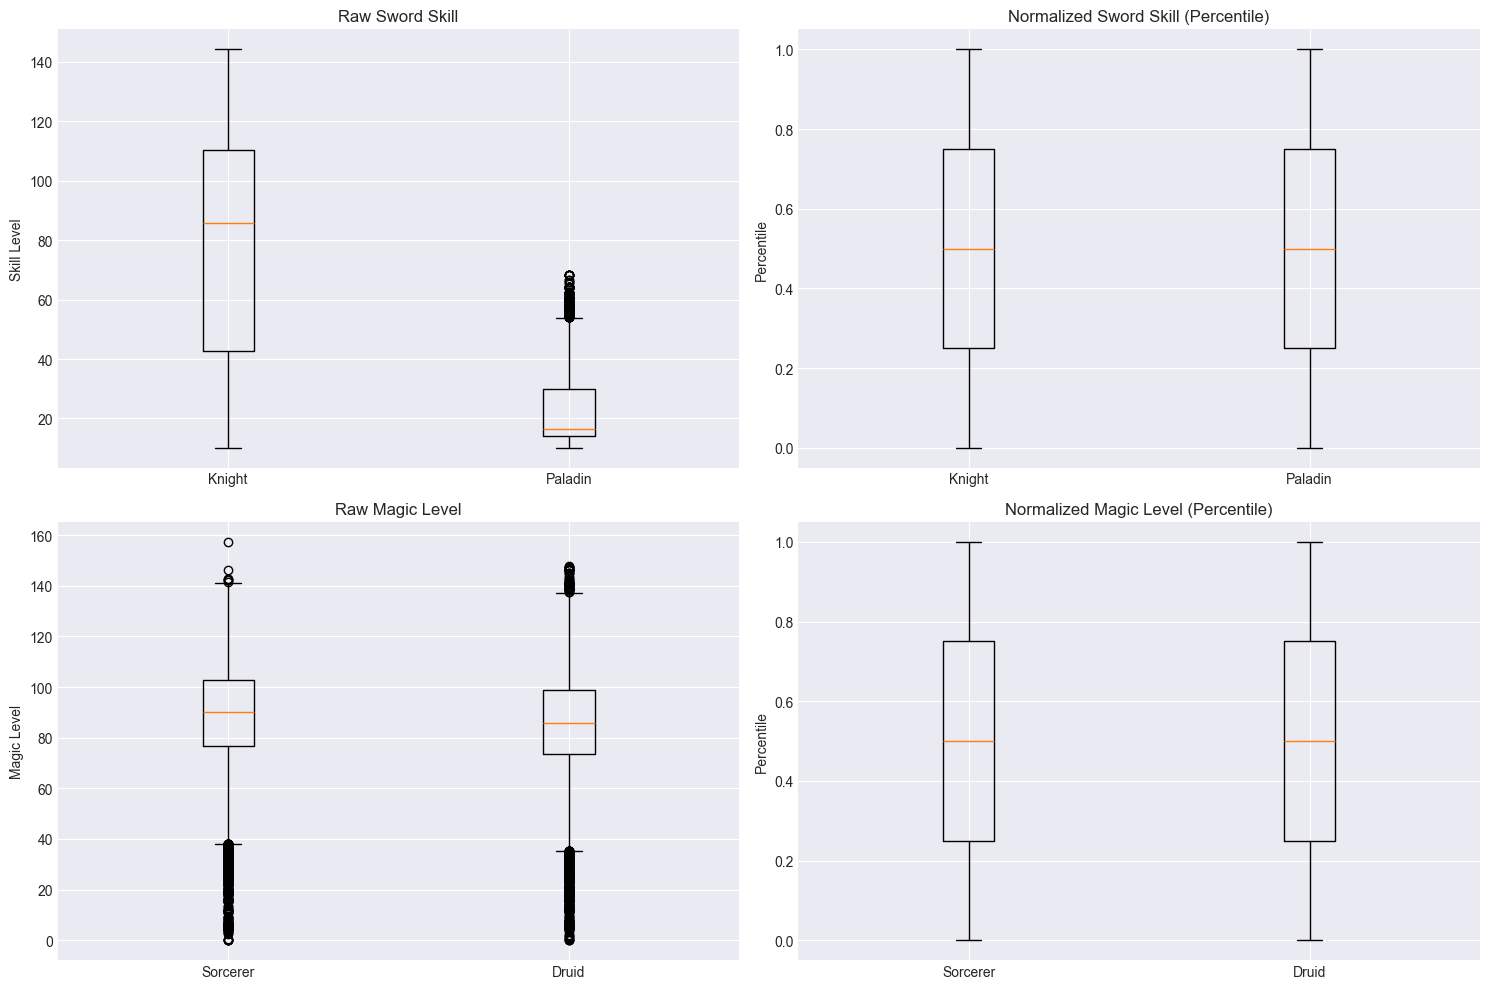

In [32]:

print("Skill distribution comparison - Raw vs Percentile:")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Data filtration to avoid empty groups 
knight_data = auctions_df[auctions_df['vocation_id']==1]
paladin_data = auctions_df[auctions_df['vocation_id']==2]
sorcerer_data = auctions_df[auctions_df['vocation_id']==4]
druid_data = auctions_df[auctions_df['vocation_id']==3]

# Raw sword skill by vocation
axes[0,0].boxplot([knight_data['sword'], paladin_data['sword']], 
                  labels=['Knight', 'Paladin'])
axes[0,0].set_title('Raw Sword Skill')
axes[0,0].set_ylabel('Skill Level')

# Normalized sword skill by vocation  
axes[0,1].boxplot([knight_data['sword_percentile'], paladin_data['sword_percentile']], 
                  labels=['Knight', 'Paladin'])
axes[0,1].set_title('Normalized Sword Skill (Percentile)')
axes[0,1].set_ylabel('Percentile')

# Raw magic skill
axes[1,0].boxplot([sorcerer_data['magic'], druid_data['magic']], 
                  labels=['Sorcerer', 'Druid'])
axes[1,0].set_title('Raw Magic Level')
axes[1,0].set_ylabel('Magic Level')

# Normalized magic skill
axes[1,1].boxplot([sorcerer_data['magic_percentile'], druid_data['magic_percentile']], 
                  labels=['Sorcerer', 'Druid'])
axes[1,1].set_title('Normalized Magic Level (Percentile)')
axes[1,1].set_ylabel('Percentile')

plt.tight_layout()
plt.show()


**Purpose of the analysis:**
Skills in Tibia have extremely different difficulty levels depending on the profession. For example, Magic Level 100 for a Druid is standard, while it's unattainable for a Knight. Sword Fighting, on the other hand, 120 is the domain of Knights, while for Paladins it's unheard of.

**What do the above graphs show?**

**Raw graphs** show actual skill levels. We see huge disparities in skill ranges (e.g., Knight's Sword Skill vs. Paladin), making it impossible to fit them into a single model without transformation.

**Normalized graphs** (Percentile) bring all skills to a common scale of 0.0 - 1.0.

A value of 0.5 means the character is strictly "average" in their profession.

A value of 0.99 means the character is in the top 1% of their profession for a given skill.

Thanks to this transformation, the future model will not have to learn the price dependence from zero for each profession separately. Instead, it will receive a clear message: "This character is in the top 5% of their class," which is a strong signal of a price increase (Current Bid), regardless of whether they are Knight or Sorcerer.

In [33]:
vocation_mapping = {
    0: 'None/Rokie',
    1: 'Knight', #high malee skills
    2: 'Paladin', #high distance and shielding
    3: 'Druid', #high magic
    4: 'Sorcerer', #high magic
    5: 'Monk' #high fist
 }

auctions_df['vocation_name'] = auctions_df['vocation_id'].map(vocation_mapping)

#tab with names of characters instead coded
vocation_skills_named = vocation_skills.copy()
vocation_skills_named.index = vocation_skills_named.index.map(vocation_mapping)
print("\n Average skills for each profession:")
display(vocation_skills_named)



 Average skills for each profession:


,avg_magic,avg_distance,avg_sword,avg_axe,avg_club,avg_shielding,avg_fist,count
vocation_id,,,,,,,,
None/Rokie,2.206,14.448,17.822,13.446,13.716,21.977,12.256,2331
Knight,9.474,19.211,75.298,58.582,53.218,101.246,16.090,365570
Paladin,26.336,111.997,21.495,16.429,18.513,99.714,16.388,331753
Druid,86.116,15.621,14.844,12.882,13.565,33.508,13.425,214652
Sorcerer,89.667,16.609,15.768,13.191,14.128,33.833,13.760,269320
Monk,31.627,13.890,14.040,13.505,13.978,57.689,88.258,10131


In [62]:
sold_auctions = auctions_df[auctions_df['has_been_bidded'] == True]
unsold_auctions = auctions_df[auctions_df['has_been_bidded'] == False]

# basic dataset statistics
print("Dataset Overview:")
print(f"Total auctions: {len(auctions_df):,}")
print(f"Sold auctions: {len(sold_auctions):,}")
print(f"Unsold auctions: {len(unsold_auctions):,}")
print(f"Date range: {auctions_df['auction_end_dt'].min().strftime('%d-%m-%Y')} to {auctions_df['auction_end_dt'].max().strftime('%d-%m-%Y')}")

# Price statistics just for sold auctions
sold_auctions = auctions_df[auctions_df['has_been_bidded']==True]
print(f"Price range (sold only): {sold_auctions['current_bid'].min():,} - {sold_auctions['current_bid'].max():,} TC")

print(f"Price range (unsold only): {unsold_auctions['current_bid'].min():,} - {unsold_auctions['current_bid'].max():,} TC")

print("\nPrice Statistics (Sold Auctions Only):")
price_stats = sold_auctions['current_bid'].describe(percentiles=[.25, .5, .75, .90, .95, .99]).round(3)
display(price_stats)

# Character level statistics for all auctions
print("\nCharacter Level Statistics (All Auctions):")
level_stats = auctions_df['level'].describe(percentiles=[.25, .5, .75, .90, .95, .99]).round(3)
display(level_stats)

# Character level statistics for sold auctions only
print("\nCharacter Level Statistics (Sold Auctions Only):")
sold_level_stats = sold_auctions['level'].describe(percentiles=[.25, .5, .75, .90, .95, .99]).round(3)
display(sold_level_stats)

# Character level statistics for unsold auctions only
unsold_auctions = auctions_df[auctions_df['has_been_bidded']==False]
print("\nCharacter Level Statistics (Unsold Auctions Only):")
unsold_level_stats = unsold_auctions['level'].describe(percentiles=[.25, .5, .75, .90, .95, .99]).round(3)
display(unsold_level_stats)

# Distribution by key variables
print("\nVocation Distribution:")
print(auctions_df['vocation_name'].value_counts())

print("\nPvP Type Distribution:")
print(auctions_df['pvp_type'].value_counts())

print("\nLocation Distribution:")
print(auctions_df['location'].value_counts())


Dataset Overview:
Total auctions: 1,193,757
Sold auctions: 815,152
Unsold auctions: 378,605
Date range: 27-11-2021 to 17-12-2025
Price range (sold only): 57 - 1,100,000 TC
Price range (unsold only): 57 - 1,222,222,222 TC

Price Statistics (Sold Auctions Only):


count     815152.000
mean        3349.994
std         8985.060
min           57.000
25%          286.000
50%         1000.000
75%         3000.000
90%         7401.000
95%        14001.000
99%        39651.000
max      1100000.000
Name: current_bid, dtype: float64


Character Level Statistics (All Auctions):


count    1193757.000
mean         318.731
std          248.240
min            8.000
25%          124.000
50%          272.000
75%          448.000
90%          652.000
95%          800.200
99%         1104.000
max         2610.000
Name: level, dtype: float64


Character Level Statistics (Sold Auctions Only):


count    815152.000
mean        295.119
std         225.064
min           8.000
25%         119.000
50%         255.000
75%         416.000
90%         603.000
95%         730.000
99%        1005.000
max        2610.000
Name: level, dtype: float64


Character Level Statistics (Unsold Auctions Only):


count    378605.000
mean        369.569
std         285.403
min           8.000
25%         139.000
50%         321.000
75%         521.000
90%         758.000
95%         921.000
99%        1238.000
max        2610.000
Name: level, dtype: float64


Vocation Distribution:
vocation_name
Knight        365570
Paladin       331753
Sorcerer      269320
Druid         214652
Monk           10131
None/Rokie      2331
Name: count, dtype: int64

PvP Type Distribution:
pvp_type
Open              553284
Optional          486863
Retro Open         98993
Retro Hardcore     47590
Hardcore            7027
Name: count, dtype: int64

Location Distribution:
location
BR     536942
EU     354890
NA     299663
OCE      2262
Name: count, dtype: int64


The dataset encompasses a massive sample of **1,193,757** auctions recorded between **November 2021 and November 2025**, including **815,152** sold auctions and **387,605** unsold auctions. This extensive timeframe and volume provide a solid foundation for understanding the Tibia market, where character prices range from a symbolic **57 TC** to a record-breaking **1,100,000 TC**.

**Approximately 32% of all auctions fail to attract buyers**, revealing significant market selectivity. Unsold auctions tend to feature higher-level characters - with a **mean level of 370 compared to 295 for sold auctions**. This counterintuitive pattern suggests that ultra-high-level characters face selling challenges, likely due to prohibitive pricing or niche appeal that limits the buyer pool.

When looking at the price and level structures, we see a heavily **skewed market**. While the **median** price sits at **1,000 TC** and the **median level** at **255**, these "average" figures don't tell the whole story. The data reveals a significant **"elite gap"**, where **the top 1% of auctions start at approximately 40,000 TC and involve characters above level 1,000**. This suggests that market value is **not linear**; instead, there is a massive price premium for ultra-high-level characters that sit at the very edge of the distribution.

The market appears to have a **"sweet spot" for character levels around 200-40**0**, where demand and pricing align most effectively. Characters significantly above this range, while objectively more powerful, struggle to find buyers willing to pay premium prices.

In terms of market composition, **Knights** and **Paladins** are the **most frequently traded vocations**, likely reflecting their high utility as efficient solo-hunting and profit-making classes. 
Geographically, the **market** is **dominated** by **South American (BR) servers**, which nearly double the auction volume of Europe or North America. Most of these transactions occur within **Open** and **Optional PvP** game worlds, which together represent the vast majority of the trading activity.



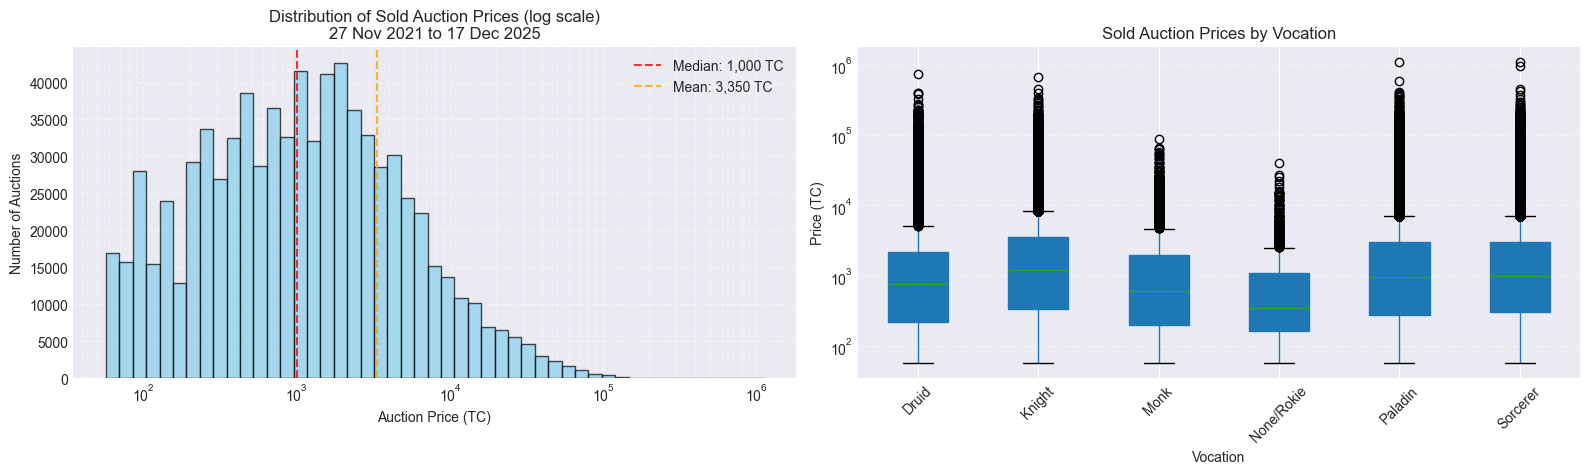

Sold Auctions Price Statistics:
Total sold auctions: 815,152
Price range: 57 - 1,100,000 TC
Median price: 1,000 TC
Mean price: 3,350 TC
95th percentile: 14,001 TC


In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

#ONLY SOLD auctions fr price analysis
sold_auctions = auctions_df[auctions_df['has_been_bidded'] ==True]
prices = sold_auctions['current_bid'].dropna()

# Histogram with log-scaled X axis
bins = np.logspace(np.log10(prices.min()), np.log10(prices.max()), 50)
ax1.hist(prices, bins=bins, edgecolor='black', alpha=0.7, color='skyblue')
ax1.set_xscale('log')
ax1.set_xlabel('Auction Price (TC)')
ax1.set_ylabel('Number of Auctions')
ax1.set_title('Distribution of Auction Prices (log scale)')
ax1.grid(True, which='both', linestyle='--', alpha=0.5)

# Add date range to title 
date_min = auctions_df['auction_end_dt'].min().strftime('%d %b %Y')  
date_max = auctions_df['auction_end_dt'].max().strftime('%d %b %Y')
ax1.set_title(f'Distribution of Sold Auction Prices (log scale)\n{date_min} to {date_max}')

ax1.grid(True, which='both', linestyle='--', alpha=0.5)

# Add statistics text
median_price = prices.median()
mean_price = prices.mean()
ax1.axvline(median_price, color='red', linestyle='--', alpha=0.8, label=f'Median: {median_price:,.0f} TC')
ax1.axvline(mean_price, color='orange', linestyle='--', alpha=0.8, label=f'Mean: {mean_price:,.0f} TC')
ax1.legend()

# Boxplot by vocation
sold_auctions.boxplot(column='current_bid', 
                   by='vocation_name', 
                   ax=ax2,
                   showfliers=True,
                   patch_artist=True)
ax2.set_title('Sold Auction Prices by Vocation')
ax2.set_xlabel('Vocation')
ax2.set_ylabel('Price (TC)')
ax2.set_yscale('log')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, axis='y', linestyle='--', alpha=0.5)

# Remove automatic pandas title
plt.suptitle('')
plt.tight_layout()
plt.show()

# Print some insights
print(f"Sold Auctions Price Statistics:")
print(f"Total sold auctions: {len(prices):,}")
print(f"Price range: {prices.min():,} - {prices.max():,} TC")
print(f"Median price: {median_price:,.0f} TC")
print(f"Mean price: {mean_price:,.0f} TC")
print(f"95th percentile: {prices.quantile(0.95):,.0f} TC")


To better understand the financial landscape of the market, I analyzed the distribution of auction prices using a logarithmic scale. This approach is necessary because the **Tibia market is highly polarized**; while the vast majority of transactions occur at lower price points, a small number of "luxury" auctions reach values in the **millions**. By using a **log scale**, we can clearly see the **market's center of gravity around the 1,000 TC median**, while the gap between the median and the 3,350 TC mean highlights how heavily the top-tier characters influence the overall average.

Comparing prices across different vocations reveals further insights into market demand. The boxplot analysis shows that while all vocations have a similar baseline price, their ceilings and distributions vary. Knights and Paladins show a very dense concentration of auctions, reflecting their role as the "backbone" of the market. In contrast, the magical vocations—Druids and Sorcerers—often show a wide range of high-value outliers, likely representing highly optimized characters with expensive magic level progress. This visualization confirms that while any vocation can reach high prices, the "rarity premium" (the 95th percentile starting at 14,000 TC) is a threshold only the most developed characters across all classes manage to cross.

# World Distribution

In [65]:
print("=== WORLD DISTRIBUTION ANALYSIS ===\n")

# 1. Auctions by Region
print("1. Auctions by Region:")
region_counts = auctions_df['location'].value_counts()
print(region_counts)
print(f"\nPercentage distribution:")
region_pct = (region_counts / len(auctions_df) * 100).round(2)
print(region_pct)

# 2. Auctions by PvP Type
print("\n2. Auctions by PvP Type:")
pvp_counts = auctions_df['pvp_type'].value_counts()
print(pvp_counts)
print(f"\nPercentage distribution:")
pvp_pct = (pvp_counts / len(auctions_df) * 100).round(2)
print(pvp_pct)

# 3. BattlEye Impact
print("\n3. BattlEye Impact:")
battleye_counts = auctions_df['battleye'].value_counts()
print(f"BattlEye enabled: {battleye_counts[True]:,}")
print(f"BattlEye disabled: {battleye_counts[False]:,}")
battleye_pct = (battleye_counts / len(auctions_df) * 100).round(2)
print(f"\nPercentage with BattlEye: {battleye_pct[True]:.2f}%")

=== WORLD DISTRIBUTION ANALYSIS ===

1. Auctions by Region:
location
BR     536942
EU     354890
NA     299663
OCE      2262
Name: count, dtype: int64

Percentage distribution:
location
BR     44.98
EU     29.73
NA     25.10
OCE     0.19
Name: count, dtype: float64

2. Auctions by PvP Type:
pvp_type
Open              553284
Optional          486863
Retro Open         98993
Retro Hardcore     47590
Hardcore            7027
Name: count, dtype: int64

Percentage distribution:
pvp_type
Open              46.35
Optional          40.78
Retro Open         8.29
Retro Hardcore     3.99
Hardcore           0.59
Name: count, dtype: float64

3. BattlEye Impact:
BattlEye enabled: 504,521
BattlEye disabled: 689,236

Percentage with BattlEye: 42.26%


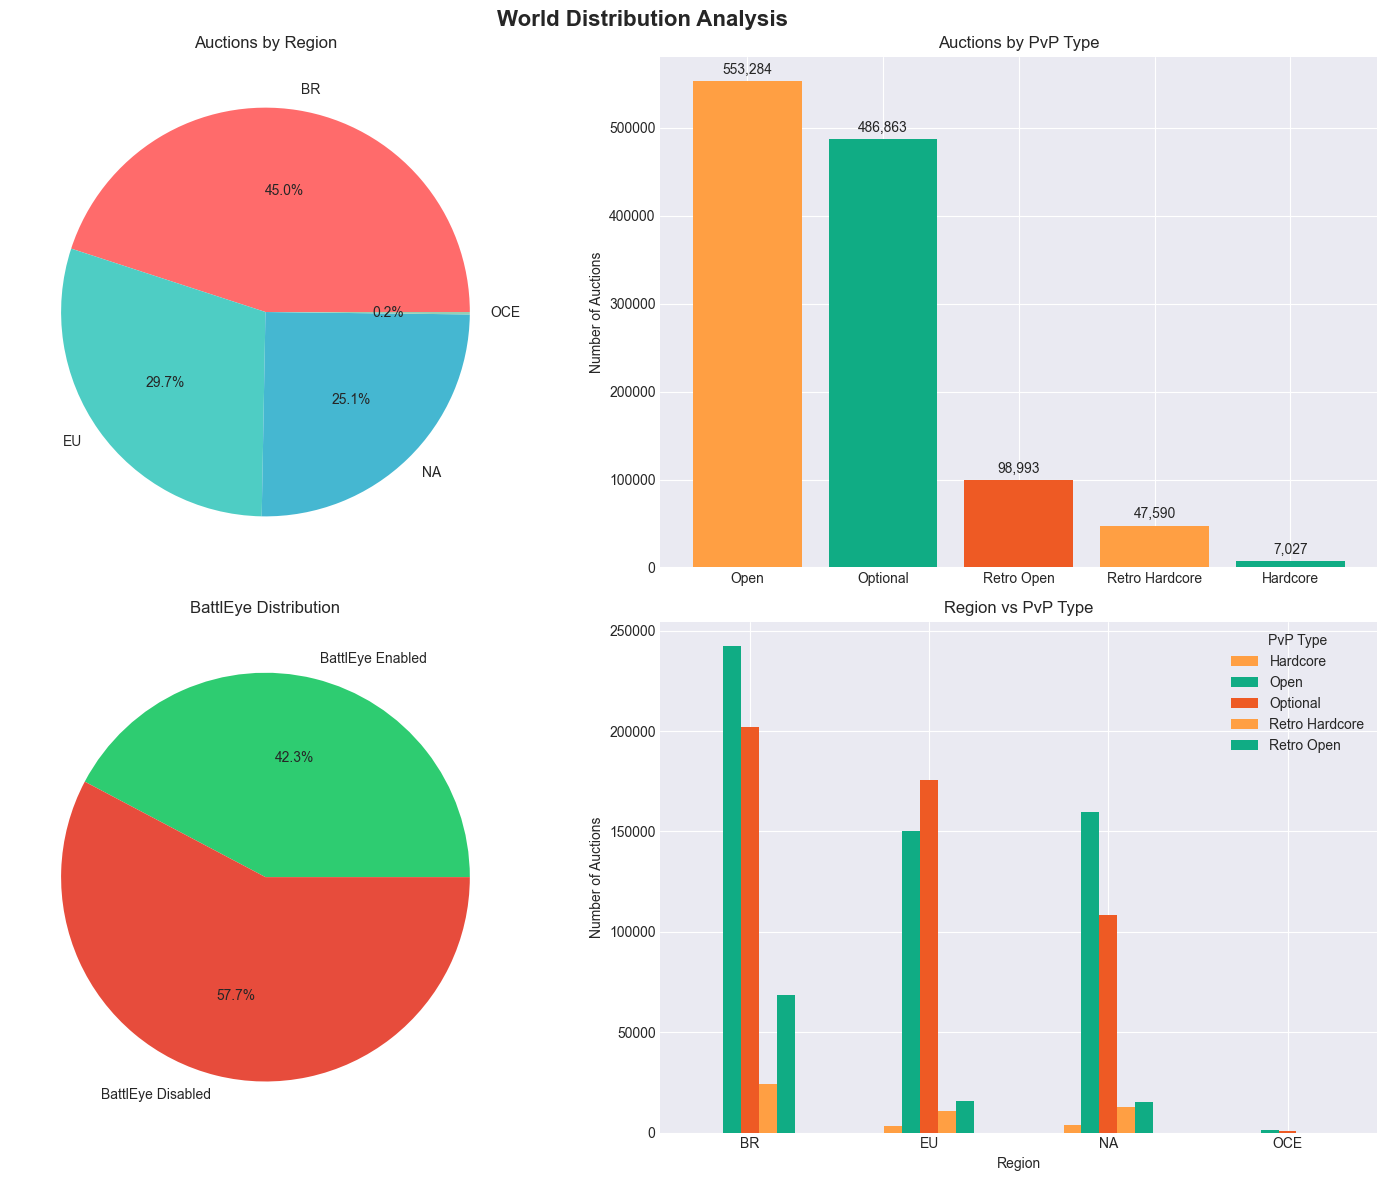

In [66]:
# Visualizations for World Distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('World Distribution Analysis', fontsize=16, fontweight='bold')

# 1. Region Distribution
axes[0, 0].pie(region_counts.values, labels=region_counts.index, autopct='%1.1f%%', 
               colors=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
axes[0, 0].set_title('Auctions by Region')

# 2. PvP Type Distribution
axes[0, 1].bar(pvp_counts.index, pvp_counts.values, color=['#FF9F43', '#10AC84', '#EE5A24'])
axes[0, 1].set_title('Auctions by PvP Type')
axes[0, 1].set_ylabel('Number of Auctions')
for i, v in enumerate(pvp_counts.values):
    axes[0, 1].text(i, v + 5000, f'{v:,}', ha='center', va='bottom')

# 3. BattlEye Distribution
battleye_labels = ['BattlEye Enabled', 'BattlEye Disabled']
battleye_values = [battleye_counts[True], battleye_counts[False]]
axes[1, 0].pie(battleye_values, labels=battleye_labels, autopct='%1.1f%%', 
               colors=['#2ECC71', '#E74C3C'])
axes[1, 0].set_title('BattlEye Distribution')

# 4. Cross-analysis: Region vs PvP Type
region_pvp = pd.crosstab(auctions_df['location'], auctions_df['pvp_type'])
region_pvp.plot(kind='bar', ax=axes[1, 1], color=['#FF9F43', '#10AC84', '#EE5A24'])
axes[1, 1].set_title('Region vs PvP Type')
axes[1, 1].set_xlabel('Region')
axes[1, 1].set_ylabel('Number of Auctions')
axes[1, 1].legend(title='PvP Type')
axes[1, 1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


The analysis of **world distribution reveals a highly concentrated market**, with the **South American (BR) region acting as the primary hub**, hosting nearly half of all global auction activity. As seen in the regional breakdown, this is followed by Europe and North America, while the Oceanic market remains a minimal fraction of the global trade. This geographic dominance suggests a very liquid market in the Brazilian region, where players can find or sell characters with much greater ease than in other territories.

When examining game mechanics, the preference of the player base is clearly oriented toward Open and Optional PvP settings, which together encompass nearly **88%** of all listings. The visualizations highlight how these two categories dwarf the more niche "Retro" and "Hardcore" formats, indicating that the vast majority of market capital is tied to standard rulesets. Interestingly, while Open PvP is the global favorite, the cross-analysis shows that engagement varies by region, with South America showing particularly high diversity in server types.

Finally, the **BattlEye security system** presents a significant split in the market. With approximately **42% of characters** originating from **"Green" (BattlEye Protected)** worlds, there is a clear divide in the ecosystem. Because characters from these protected environments cannot be transferred to older "Yellow" worlds, this technical restriction creates two distinct sub-markets. For the future predictive model, this distinction will be a vital price driver, as characters from protected worlds often command a "purity" premium due to the strictly enforced anti-cheat history of their servers.

In [56]:
# Detailed Cross-Analysis
print("\n=== DETAILED CROSS-ANALYSIS ===\n")

# Region vs PvP Type crosstab
print("Region vs PvP Type:")
region_pvp_table = pd.crosstab(auctions_df['location'], auctions_df['pvp_type'], margins=True)
print(region_pvp_table)

print("\nPercentage within each region:")
region_pvp_pct = pd.crosstab(auctions_df['location'], auctions_df['pvp_type'], normalize='index') * 100
print(region_pvp_pct.round(2))

# Region vs BattlEye
print("\n\nRegion vs BattlEye:")
region_battleye = pd.crosstab(auctions_df['location'], auctions_df['battleye'], margins=True)
print(region_battleye)

print("\nPercentage with BattlEye by region:")
region_battleye_pct = pd.crosstab(auctions_df['location'], auctions_df['battleye'], normalize='index') * 100
print(region_battleye_pct.round(2))

# PvP Type vs BattlEye
print("\n\nPvP Type vs BattlEye:")
pvp_battleye = pd.crosstab(auctions_df['pvp_type'], auctions_df['battleye'], margins=True)
print(pvp_battleye)

print("\nPercentage with BattlEye by PvP type:")
pvp_battleye_pct = pd.crosstab(auctions_df['pvp_type'], auctions_df['battleye'], normalize='index') * 100
print(pvp_battleye_pct.round(2))



=== DETAILED CROSS-ANALYSIS ===

Region vs PvP Type:
pvp_type  Hardcore    Open  Optional  Retro Hardcore  Retro Open      All
location                                                                 
BR               0  242405    202237           23978       68322   536942
EU            3104  150002    175485           10694       15605   354890
NA            3923  159577    108179           12918       15066   299663
OCE              0    1300       962               0           0     2262
All           7027  553284    486863           47590       98993  1193757

Percentage within each region:
pvp_type  Hardcore   Open  Optional  Retro Hardcore  Retro Open
location                                                       
BR            0.00  45.15     37.66            4.47       12.72
EU            0.87  42.27     49.45            3.01        4.40
NA            1.31  53.25     36.10            4.31        5.03
OCE           0.00  57.47     42.53            0.00        0.00


Region vs 

**Investigating the hidden relationships between region, server type, and protection system. In character trading, these three factors do not operate in isolation – their combination creates unique "market niches" that determine the final auction price.**



**Dominance and Specificity of the BR (Brazil) Region:**

Scale: The BR region generates nearly 45% of all auctions (over 536,000 records). This is an absolutely crucial market for the model's stability.

I noticed that Brazil has a significantly higher percentage of Retro Open PvP servers (12.72%) compared to Europe (4.40%) or North America (5.03%). This suggests that the model must account for the specific "premium" Retro servers in this region.


**Geographic Technology Divide (Green vs. Yellow BattlEye):**

The analysis revealed a clear technological divide across the world. The **BR** and **OCE** regions are **"modern" markets** (57% and 72%, respectively, are **Green servers**).

In contrast, **EU** and **NA** are **"historical" markets**, dominated by old **Yellow servers** (approximately 68% and 73%).

The predictive model will need to differentiate the purchasing power of players from different regions based on BattlEye status. A character in a Green world in Europe (where there are few of them) may be relatively more expensive than in a Green world in Brazil.


**Collinearity of Variables (PvP vs. BattlEye):**

**Retro Hardcore PvP is always (100%) Green servers, while Hardcore PvP is always (100%) Yellow servers.**

Conclusion for Feature Engineering: Introducing both of these variables in their raw form into a linear model could lead to multicollinearity bias. When building the model (especially XGBoost/LightGBM), these relationships will be used to build stronger decision trees.


**Player Profile -  Europe vs. North America:**

In North America (NA), the Open PvP playstyle is dominant (53.25%).

Europe (EU) is more divided, with a slight preponderance of recreational players in Optional PvP (49.45%).

For the model, this means that high-level characters (High Level) may be more highly valued in NA on PvP servers, while in EU, the high price may more often result from unique outfits/mounts on non-PvP worlds.


# Vocation analysis

In [59]:
print("=== VOCATION ANALYSIS ===\n")

# 1. Auctions by Vocation ID - all auctions
print("1. Auctions by Vocation:")
vocation_counts = auctions_df['vocation_id'].value_counts().sort_index()
print(vocation_counts)
print(f"\nPercentage distribution:")
vocation_pct = (vocation_counts / len(auctions_df) * 100).round(2)
print(vocation_pct)

# 2. Average level by vocation - all auctions
print("\n2. Average Level by Vocation:")
avg_level_vocation = auctions_df.groupby('vocation_id')['level'].agg(['mean', 'median', 'std']).round(2)
print(avg_level_vocation)

# 3. Average price by vocation - sold only
print("\n3. Average Price by Vocation (Sold Auctions Only):")
avg_price_vocation = sold_auctions.groupby('vocation_id')['current_bid'].agg(['mean', 'median', 'std']).round(0)
print(avg_price_vocation)


=== VOCATION ANALYSIS ===

1. Auctions by Vocation:
vocation_id
0      2331
1    365570
2    331753
3    214652
4    269320
5     10131
Name: count, dtype: int64

Percentage distribution:
vocation_id
0     0.20
1    30.62
2    27.79
3    17.98
4    22.56
5     0.85
Name: count, dtype: float64

2. Average Level by Vocation:
               mean  median     std
vocation_id                        
0             33.73    25.0   29.37
1            338.33   308.0  257.68
2            306.62   264.0  246.62
3            295.74   243.0  242.15
4            333.48   287.0  240.27
5            168.57   147.0  138.94

3. Average Price by Vocation (Sold Auctions Only):
               mean  median     std
vocation_id                        
0            1315.0   351.0  2743.0
1            3504.0  1200.0  8233.0
2            3436.0   961.0  9577.0
3            3015.0   750.0  9099.0
4            3376.0  1001.0  9273.0
5            1994.0   604.0  4341.0


**Market Supply (All Auctions):**
 The entire market is dominated by Knights (30.62%) and Paladins (27.79%). They account for nearly 60% of all auctions, suggesting the highest liquidity for these professions.

**Market Value (Sold Auctions Only):**
 Despite high supply, Knights maintain the highest median price (1200 TC), indicating strong and stable demand. Sorcerers are the lowest priced (median 750 TC).

**Price Structure (Sold Auctions - Skew):**
 The huge difference between the mean and median (e.g., 3504 TC vs. 1200 TC for Knights) indicates the presence of unique characters (outliers) with extremely high prices.

**Leveling Potential (All auctions):**
 Druids and Knights achieve the highest average levels (~310 levels), which may be due to their key role in effective Team Hunting.

# Levels Distribution

In [72]:
print("=== LEVEL DISTRIBUTION ANALYSIS ===\n")

# 1. Basic level statistics
print("1. Level Statistics (All Auctions):")
level_stats = auctions_df['level'].describe()
print(level_stats)

# 2. Level segmentation
print("\n2. Level Segmentation (All Auctions):")
def categorize_level(level):
    if level < 100:
        return 'Low (< 100)'
    elif level < 300:
        return 'Mid (100-299)'
    elif level < 500:
        return 'High (300-499)'
    else:
        return 'Very High (500+)'

auctions_df['level_category'] = auctions_df['level'].apply(categorize_level)
level_cat_counts = auctions_df['level_category'].value_counts()
print(level_cat_counts)
print(f"\nPercentage distribution:")
level_cat_pct = (level_cat_counts / len(auctions_df) * 100).round(2)
print(level_cat_pct)

# 3. Price per level analysis
print("\n3. Price per Level Analysis (Sold Auctions Only):")
sold_auctions['price_per_level'] = sold_auctions['current_bid'] / sold_auctions['level']
price_per_level_stats = sold_auctions['price_per_level'].describe()
print(price_per_level_stats)


=== LEVEL DISTRIBUTION ANALYSIS ===

1. Level Statistics (All Auctions):
count    1.193757e+06
mean     3.187310e+02
std      2.482397e+02
min      8.000000e+00
25%      1.240000e+02
50%      2.720000e+02
75%      4.480000e+02
max      2.610000e+03
Name: level, dtype: float64

2. Level Segmentation (All Auctions):
level_category
Mid (100-299)       410336
High (300-499)      305750
Very High (500+)    242353
Low (< 100)         235318
Name: count, dtype: int64

Percentage distribution:
level_category
Mid (100-299)       34.37
High (300-499)      25.61
Very High (500+)    20.30
Low (< 100)         19.71
Name: count, dtype: float64

3. Price per Level Analysis (Sold Auctions Only):
count    815152.000000
mean          8.972604
std          51.307416
min           0.211111
25%           2.391304
50%           4.661491
75%           8.787346
max       27203.250000
Name: price_per_level, dtype: float64


**Market Segmentation:** 
 The market is dominated by mid- and high-level characters (levels 100–499), who account for over 60% of all auctions. The largest group is "Mid Level" (34.4%).

**Growth Dynamics:**
 The average level is 319, but record-breaking characters reach up to 2610 levels. This wide range (std = 248) requires a high degree of flexibility from the model – price relationships for level 100 are completely different than for level 1000.

**Price per Level Index:**
 The median is 4.66 TC per level. This is a key metric for the "pure" value of experience.

**Anomalies (Outliers):**
 The maximum value of 27,203 TC/level (!) clearly demonstrates that at a certain point, unique features (rare items, record-breaking skills) rather than level become the primary price driver.

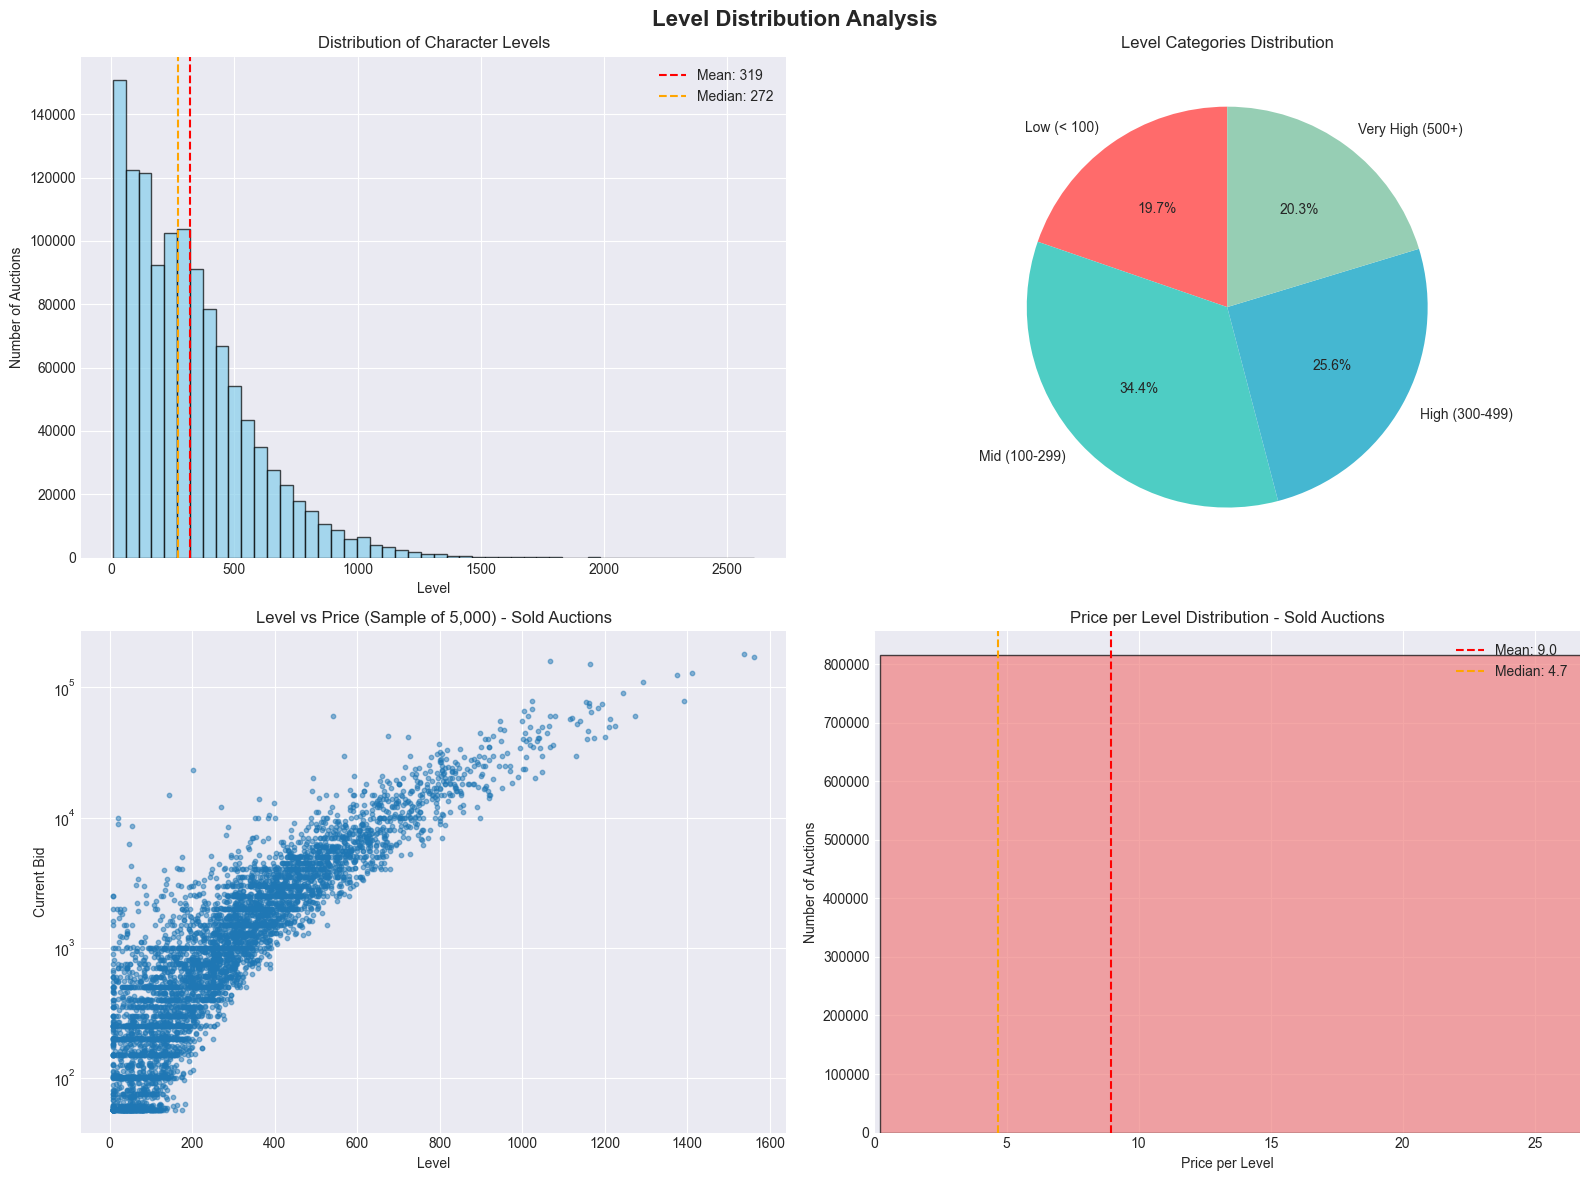

In [77]:
# Level Distribution Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Level Distribution Analysis', fontsize=16, fontweight='bold')

# 1. Level histogram
axes[0, 0].hist(auctions_df['level'], bins=50, color='skyblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Distribution of Character Levels')
axes[0, 0].set_xlabel('Level')
axes[0, 0].set_ylabel('Number of Auctions')
axes[0, 0].axvline(auctions_df['level'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {auctions_df["level"].mean():.0f}')
axes[0, 0].axvline(auctions_df['level'].median(), color='orange', linestyle='--', 
                   label=f'Median: {auctions_df["level"].median():.0f}')
axes[0, 0].legend()

# 2. Level categories pie chart
level_cat_ordered = ['Low (< 100)', 'Mid (100-299)', 'High (300-499)', 'Very High (500+)']
level_cat_counts_ordered = [level_cat_counts.get(cat, 0) for cat in level_cat_ordered]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
axes[0, 1].pie(level_cat_counts_ordered, labels=level_cat_ordered, autopct='%1.1f%%', 
               colors=colors, startangle=90)
axes[0, 1].set_title('Level Categories Distribution')

# 3. Level vs Price scatter plot SOLD AUCTIONS 
sample_size = min(5000, len(sold_auctions))  # Sample for better visualization
sample_df = sold_auctions.sample(n=sample_size, random_state=42)
axes[1, 0].scatter(sample_df['level'], sample_df['current_bid'], alpha=0.5, s=10)
axes[1, 0].set_title(f'Level vs Price (Sample of {sample_size:,}) - Sold Auctions')
axes[1, 0].set_xlabel('Level')
axes[1, 0].set_ylabel('Current Bid')
axes[1, 0].set_yscale('log')  # Log scale for better visualization

# 4. Price per level distribution
axes[1, 1].hist(sold_auctions['price_per_level'], bins=50, color='lightcoral', 
                alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Price per Level Distribution - Sold Auctions')
axes[1, 1].set_xlabel('Price per Level')
axes[1, 1].set_ylabel('Number of Auctions')
axes[1, 1].set_xlim(0, sold_auctions['price_per_level'].quantile(0.95))  # Remove extreme outliers
axes[1, 1].axvline(sold_auctions['price_per_level'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {sold_auctions["price_per_level"].mean():.1f}')
axes[1, 1].axvline(sold_auctions['price_per_level'].median(), color='orange', linestyle='--', 
                   label=f'Median: {sold_auctions["price_per_level"].median():.1f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


**Distribution Characteristics:** 
 The histogram shows a clear right-skew (long tail). Despite the median being level 272, the market has a long tail of high-level characters reaching up to level 2610, suggesting the need for models that address nonlinearity.

**Portfolio Structure:**
 The pie chart confirms that the heart of the market is the Mid & High Level segment (totaling approximately 60%). This is where the greatest character turnover occurs.

**Level vs. Price Correlation:**
 The scatter plot (on a logarithmic scale for sold auctions) reveals a strong, positive correlation between level and price. However, the significant scatter of points (noise) suggests that level isn't everything – there are other strong price predictors (e.g., rare skills or items).

**Price Efficiency:**
 The Price per Level histogram centers around 4.7 TC/level. Values ​​significantly deviating from this mean allow for the automatic detection of market gems or characters with unique collectible value.

**Model Conclusions:**
 The strong visual correlation confirms that level will be the variable of greatest importance (Feature Importance). The logarithmic scale used in the scatter plot suggests that modeling the logarithm of price (log_price) may yield a better fit (R-squared).

# Premium Feature Analysis

In [80]:
print("=== PREMIUM FEATURES ANALYSIS ===\n")

# 1. Store Items Analysis
print("1. Store Items Analysis:")
print(f"Characters with store outfits: {(auctions_df['store_outfits_count'] > 0).sum():,}")
print(f"Characters with store mounts: {(auctions_df['store_mounts_count'] > 0).sum():,}")
print(f"Percentage with store outfits: {(auctions_df['store_outfits_count'] > 0).mean() * 100:.2f}%")
print(f"Percentage with store mounts: {(auctions_df['store_mounts_count'] > 0).mean() * 100:.2f}%")

# 2. Premium Slots Analysis
print("\n2. Premium Slots Analysis:")
print(f"Characters with prey slot: {auctions_df['prey_slot'].sum():,}")
print(f"Characters with hunting slot: {auctions_df['hunting_slot'].sum():,}")
print(f"Characters with charm expansion: {auctions_df['charm_expansion'].sum():,}")
print(f"Percentage with prey slot: {auctions_df['prey_slot'].mean() * 100:.2f}%")
print(f"Percentage with hunting slot: {auctions_df['hunting_slot'].mean() * 100:.2f}%")
print(f"Percentage with charm expansion: {auctions_df['charm_expansion'].mean() * 100:.2f}%")

# 3. Collections Analysis
print("\n3. Collections Analysis:")
outfit_stats = auctions_df['outfits_count'].describe()
mount_stats = auctions_df['mounts_count'].describe()
print("Outfits count statistics:")
print(outfit_stats)
print("\nMounts count statistics:")
print(mount_stats)

# 4. Achievement Analysis
print("\n4. Achievement Analysis:")
achievement_stats = auctions_df['achievement_points'].describe()
boss_stats = auctions_df['boss_points'].describe()
print("Achievement points statistics:")
print(achievement_stats)
print("\nBoss points statistics:")
print(boss_stats)

# 5. Impact on Price (Sold Auctions Only)
print("\n5. Premium Features Impact on Sold Auctions (Median Price Comparison):")

# Porównanie mediany ceny dla postaci z Prey Slotem i bez
has_prey = sold_auctions[sold_auctions['prey_slot'] == True]['current_bid'].median()
no_prey = sold_auctions[sold_auctions['prey_slot'] == False]['current_bid'].median()

print(f"Median price with Prey Slot: {has_prey:,.0f} TC")
print(f"Median price without Prey Slot: {no_prey:,.0f} TC")
print(f"Premium Lift: {((has_prey/no_prey)-1)*100:.1f}%")

=== PREMIUM FEATURES ANALYSIS ===

1. Store Items Analysis:
Characters with store outfits: 249,166
Characters with store mounts: 149,611
Percentage with store outfits: 20.87%
Percentage with store mounts: 12.53%

2. Premium Slots Analysis:
Characters with prey slot: 211,774
Characters with hunting slot: 12,059
Characters with charm expansion: 115,969
Percentage with prey slot: 17.74%
Percentage with hunting slot: 1.01%
Percentage with charm expansion: 9.71%

3. Collections Analysis:
Outfits count statistics:
count    1.193757e+06
mean     1.949611e+01
std      8.588132e+00
min      1.100000e+01
25%      1.200000e+01
50%      1.700000e+01
75%      2.400000e+01
max      6.000000e+01
Name: outfits_count, dtype: float64

Mounts count statistics:
count    1.193757e+06
mean     8.180983e+00
std      1.010055e+01
min      0.000000e+00
25%      1.000000e+00
50%      4.000000e+00
75%      1.200000e+01
max      7.400000e+01
Name: mounts_count, dtype: float64

4. Achievement Analysis:
Achievement

**Store Investments:**
 Nearly 21% of characters have paid outfits, and 12.5% have paid mounts. These are "non-removable" features that permanently increase the base value of the account, regardless of skill.

**Elite Features Rarity:**
 While the **Prey Slot** is relatively common (**17.7%**), features like **Charm Expansion** (**9.7%**) and especially the **Hunting Slot** (**1.0%**) are rare. Their presence drastically narrows the target audience to the most dedicated players and collectors, co czyni te postacie produktami typu "premium".

**Boss Point Asymmetry:**
 The median is 0, despite an average of 580. This means that most characters on the market have not participated in the advanced boss system. Characters with a high score (up to 24,105 points) are unique and should be considered "collectible" by the model.

**Collections (Outfits/Mounts):**
The average number of outfits (19.5) and mounts (8.2) shows a high variability (std. 8.6 for outfits, 10.1 for mounts). This suggests a huge diversity of accounts – from basic characters to extensive collections, which the model must account for as a significant component of the price.

**Model implications:**
 Binary features (prey_slot, hunting_slot, charm_expansion) will act as strong price drivers. Incorporating them into the model will allow for precise differentiation between high-level "empty" characters and fully equipped "Main Character" accounts.

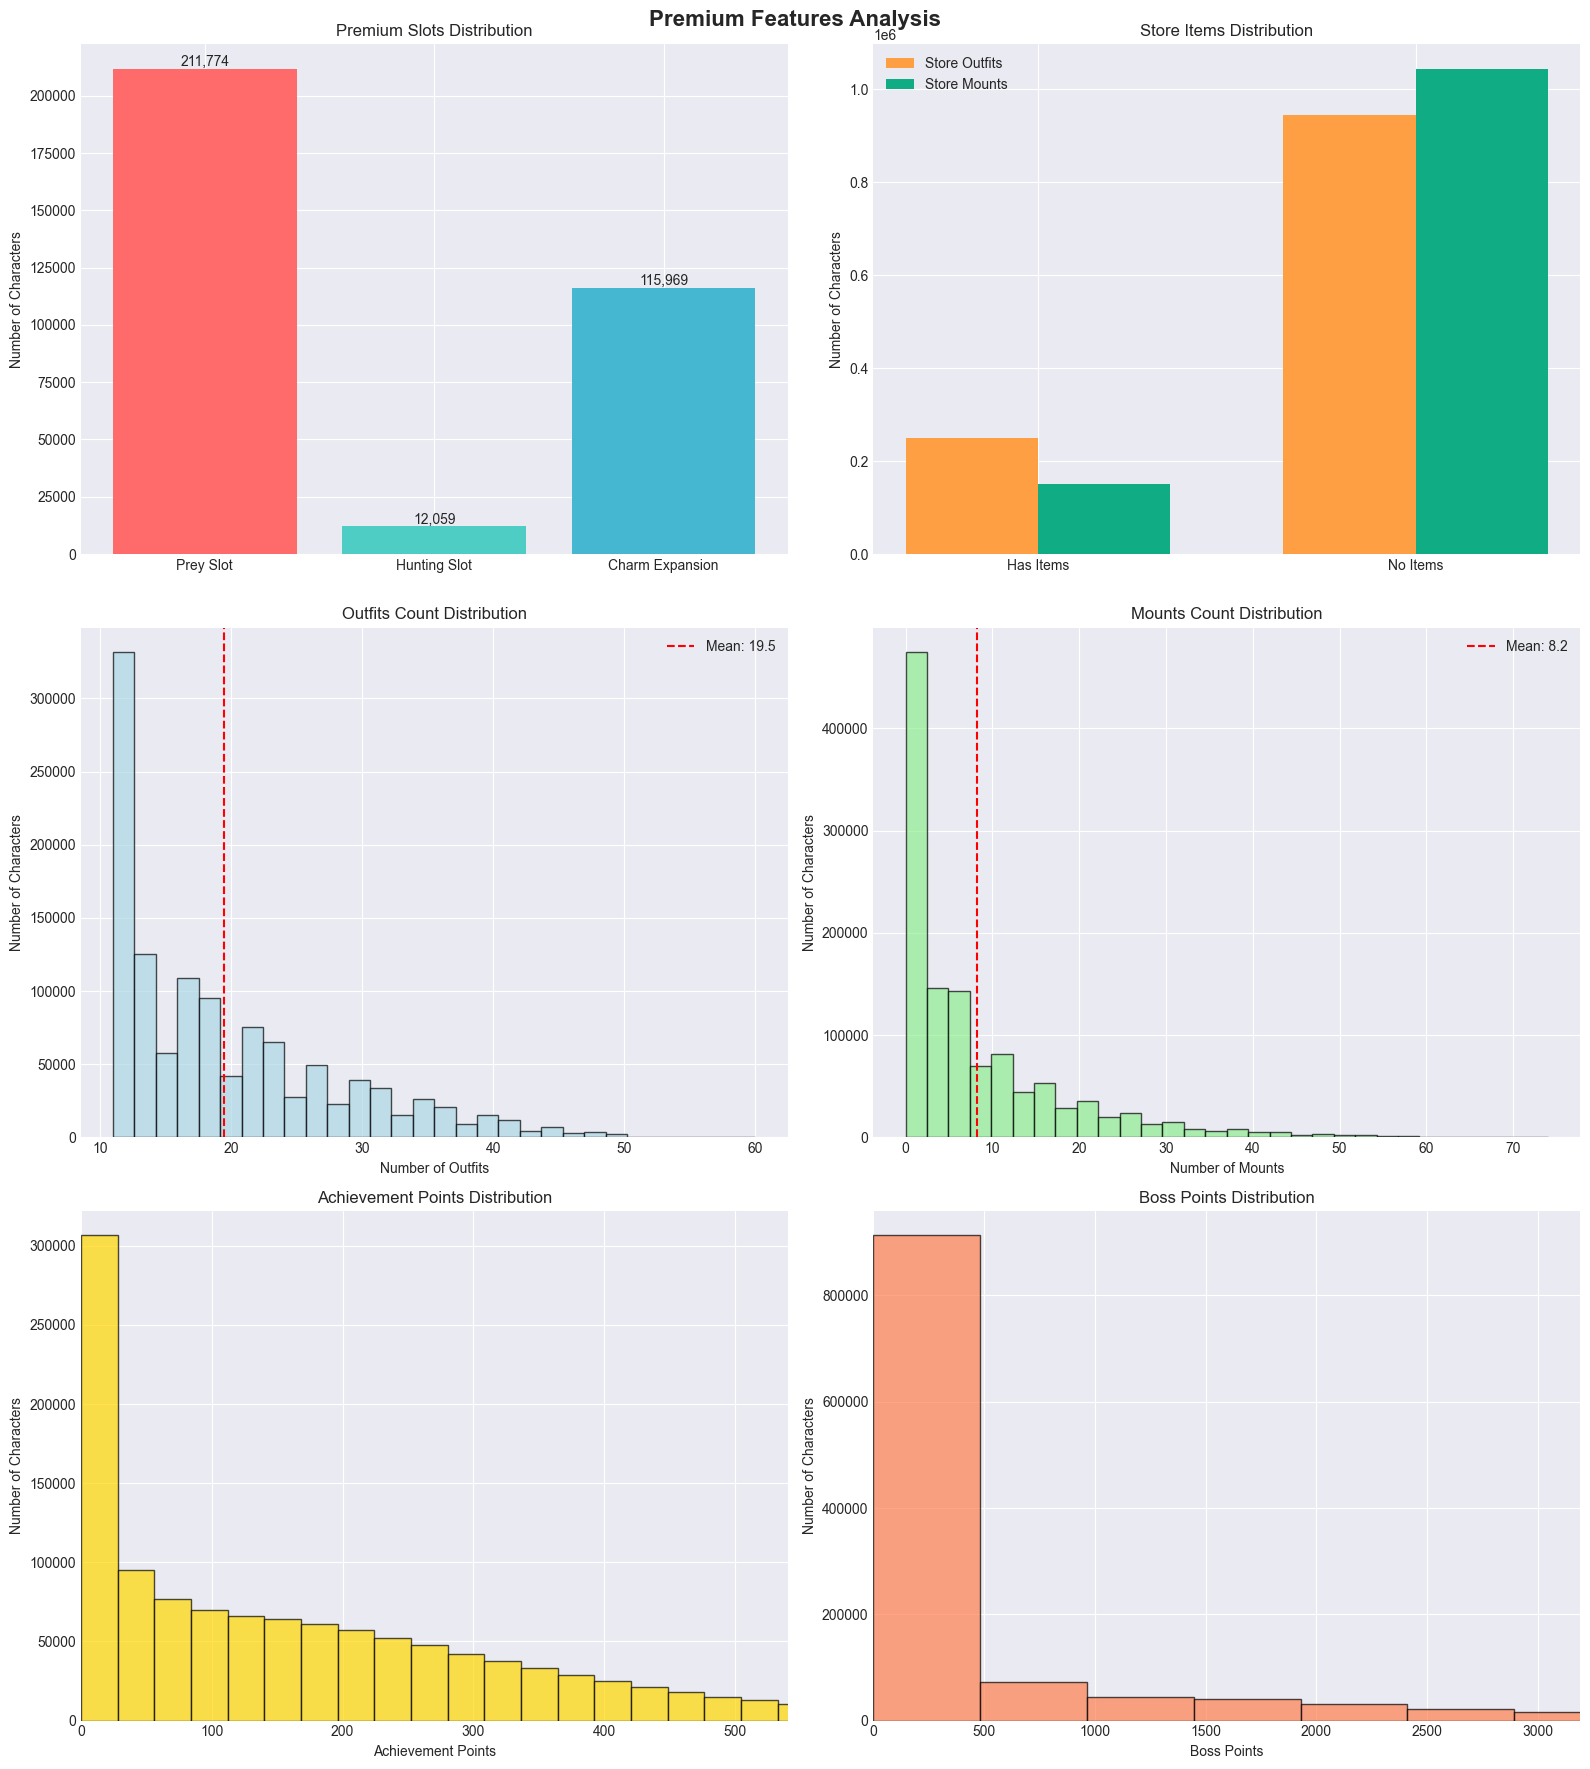

In [82]:
# Visualizations
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle('Premium Features Analysis', fontsize=16, fontweight='bold')

# 1. Premium Slots Distribution
premium_slots = ['prey_slot', 'hunting_slot', 'charm_expansion']
premium_counts = [auctions_df[slot].sum() for slot in premium_slots]
premium_labels = ['Prey Slot', 'Hunting Slot', 'Charm Expansion']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

axes[0, 0].bar(premium_labels, premium_counts, color=colors)
axes[0, 0].set_title('Premium Slots Distribution')
axes[0, 0].set_ylabel('Number of Characters')
for i, v in enumerate(premium_counts):
    axes[0, 0].text(i, v + 1.02, f'{v:,}', ha='center', va='bottom')

# 2. Store Items Distribution
store_outfit_yes = (auctions_df['store_outfits_count'] > 0).sum()
store_outfit_no = (auctions_df['store_outfits_count'] == 0).sum()
store_mount_yes = (auctions_df['store_mounts_count'] > 0).sum()
store_mount_no = (auctions_df['store_mounts_count'] == 0).sum()

store_data = {
    'Store Outfits': [store_outfit_yes, store_outfit_no],
    'Store Mounts': [store_mount_yes, store_mount_no]
}

x = np.arange(2)
width = 0.35
axes[0, 1].bar(x - width/2, store_data['Store Outfits'], width, label='Store Outfits', color='#FF9F43')
axes[0, 1].bar(x + width/2, store_data['Store Mounts'], width, label='Store Mounts', color='#10AC84')
axes[0, 1].set_title('Store Items Distribution')
axes[0, 1].set_ylabel('Number of Characters')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(['Has Items', 'No Items'])
axes[0, 1].legend()

# 3. Outfits Count Distribution
axes[1, 0].hist(auctions_df['outfits_count'], bins=30, color='lightblue', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Outfits Count Distribution')
axes[1, 0].set_xlabel('Number of Outfits')
axes[1, 0].set_ylabel('Number of Characters')
axes[1, 0].axvline(auctions_df['outfits_count'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {auctions_df["outfits_count"].mean():.1f}')
axes[1, 0].legend()

# 4. Mounts Count Distribution
axes[1, 1].hist(auctions_df['mounts_count'], bins=30, color='lightgreen', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Mounts Count Distribution')
axes[1, 1].set_xlabel('Number of Mounts')
axes[1, 1].set_ylabel('Number of Characters')
axes[1, 1].axvline(auctions_df['mounts_count'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {auctions_df["mounts_count"].mean():.1f}')
axes[1, 1].legend()

# 5. Achievement Points Distribution
axes[2, 0].hist(auctions_df['achievement_points'], bins=50, color='gold', alpha=0.7, edgecolor='black')
axes[2, 0].set_title('Achievement Points Distribution')
axes[2, 0].set_xlabel('Achievement Points')
axes[2, 0].set_ylabel('Number of Characters')
axes[2, 0].set_xlim(0, auctions_df['achievement_points'].quantile(0.95))  # Remove extreme outliers

# 6. Boss Points Distribution
axes[2, 1].hist(auctions_df['boss_points'], bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[2, 1].set_title('Boss Points Distribution')
axes[2, 1].set_xlabel('Boss Points')
axes[2, 1].set_ylabel('Number of Characters')
axes[2, 1].set_xlim(0, auctions_df['boss_points'].quantile(0.95))  # Remove extreme outliers

plt.tight_layout()
plt.show()


**Premium Feature Rarity:** 
 The bar graph confirms that the Hunting Slot is a market rarity (very low bar relative to the rest), making it a highly weighted predictor for high-end characters.

**Store Items Segmentation:**
 Most of the market doesn't have premium items, creating a clear value barrier. Characters in the "Has Items" group form a separate premium auction class.

**Collection Stability:**
 The distributions of outfits and mounts are centered around average values ​​(~19 and ~8, respectively), but long tails in the histograms indicate a "collector" group, where prices can increase exponentially with the number of add-ons owned.

**Achievement & Boss Values:**
 The strong concentration at low values ​​with a sharp decline confirms that high achievement points are an elite feature. Filtering outliers (quantile 0.95) allows for a better depiction of the market standard.

## Premium Features Price Impact on Sold Auctions

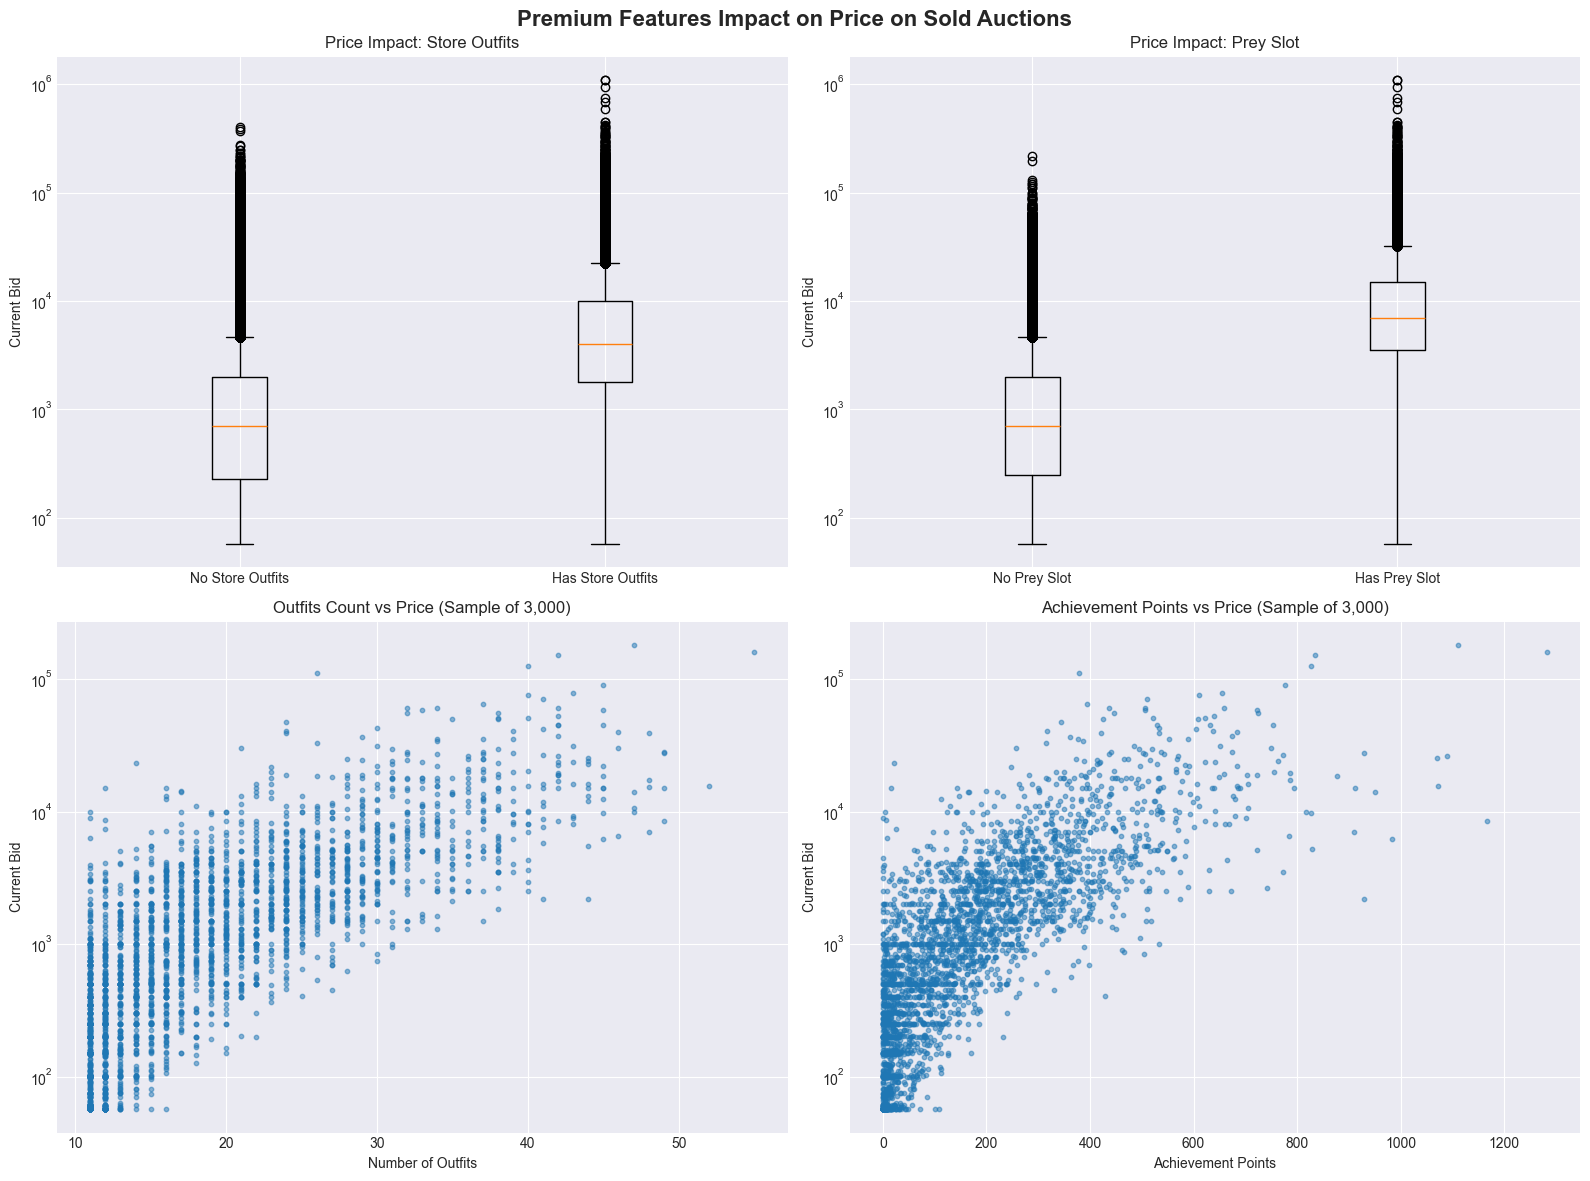

In [84]:
# Premium Features impact on Price
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Premium Features Impact on Price on Sold Auctions', fontsize=16, fontweight='bold')

# 1. Price comparison: characters with vs without store items
store_outfit_prices = [
    sold_auctions[sold_auctions['store_outfits_count'] == 0]['current_bid'],
    sold_auctions[sold_auctions['store_outfits_count'] > 0]['current_bid']
]
axes[0, 0].boxplot(store_outfit_prices, labels=['No Store Outfits', 'Has Store Outfits'])
axes[0, 0].set_title('Price Impact: Store Outfits')
axes[0, 0].set_ylabel('Current Bid')
axes[0, 0].set_yscale('log')

# 2. Price comparison: premium slots
premium_slot_prices = [
    sold_auctions[sold_auctions['prey_slot'] == False]['current_bid'],
    sold_auctions[sold_auctions['prey_slot'] == True]['current_bid']
]
axes[0, 1].boxplot(premium_slot_prices, labels=['No Prey Slot', 'Has Prey Slot'])
axes[0, 1].set_title('Price Impact: Prey Slot')
axes[0, 1].set_ylabel('Current Bid')
axes[0, 1].set_yscale('log')

# 3. Outfits count vs Price (scatter plot sample)
sample_size = min(3000, len(sold_auctions))
sample_df = sold_auctions.sample(n=sample_size, random_state=42)
axes[1, 0].scatter(sample_df['outfits_count'], sample_df['current_bid'], alpha=0.5, s=10)
axes[1, 0].set_title(f'Outfits Count vs Price (Sample of {sample_size:,})')
axes[1, 0].set_xlabel('Number of Outfits')
axes[1, 0].set_ylabel('Current Bid')
axes[1, 0].set_yscale('log')

# 4. Achievement points vs Price (scatter plot sample)
axes[1, 1].scatter(sample_df['achievement_points'], sample_df['current_bid'], alpha=0.5, s=10)
axes[1, 1].set_title(f'Achievement Points vs Price (Sample of {sample_size:,})')
axes[1, 1].set_xlabel('Achievement Points')
axes[1, 1].set_ylabel('Current Bid')
axes[1, 1].set_yscale('log')

plt.tight_layout()
plt.show()


**"Store Premium" Effect:** 
Boxplots clearly show that having paid outfits and Prey Slots significantly increases the median price. Characters with Store traits have a higher bar – they are less likely to sell for minimum prices.

**Utility Value (Prey Slot):**
 The presence of a Prey Slot drastically narrows the interquartile range (IQR). This suggests a high market consensus on the value of this feature; players focused on efficiency create a stable, high-demand segment that reduces price volatility for these characters.

**Collection Correlation:**
 Scatter plots reveal an upward trend: the more outfits and achievement points, the higher the price. However, the visible "cloud" of points suggests that achievement points have a wider spread – they are valued primarily by collectors (a niche segment).

**Nonlinearity:**
 The use of a logarithmic scale on the Y-axis was essential. Price differences between entry-level and high-end characters span several orders of magnitude (from 50 to 500,000+ TC), confirming that the market does not scale linearly with level or skills.

**Model Conclusions:**
 The inclusion of binary features (Has/No Store Items) in the model was confirmed. The dataset demonstrates market characteristics in which premium add-ons act as multipliers of the base price based on the character level.